In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/My Drive/Colab Notebooks'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
ckpt   input_Conv   NN_Conv.ipynb  Trigo_NN_FC.ipynb
input  input_trigo  NN_FC.ipynb


Create dataloaders

In [0]:
import pandas
from torch.utils.data import Dataset
class csv2Dataset(Dataset):
  def __init__(self, csv_file):
    self.frame = pandas.read_csv(csv_file, header=None)
    self.mean = self.frame.mean()
    self.std = self.frame.std()
    self.frame = self.frame.fillna(0)
    self.frame = (self.frame - self.mean) / self.std

  def getMean(self):
    return self.mean

  def getStd(self):
    return self.std

  def __len__(self):
      return len(self.frame)

  def __getitem__(self, idx):
    x = self.frame.iloc[idx, 0:72]
    y = self.frame.iloc[idx, 72]
    sample = {'x': torch.tensor(x), 'y': torch.tensor(y)}
    return sample

In [0]:
import numpy as np
import random
import torch
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models

#random.seed(0)
#torch.manual_seed(0)
#np.random.seed(0)
#torch.cuda.manual_seed(0)
#torch.backends.cudnn.determenistic = True

path = '/content/drive/My Drive/Colab Notebooks/'

train_dataset = csv2Dataset(path + 'input_trigo/train.csv')
test_dataset = csv2Dataset(path + 'input_trigo/test.csv')
val_dataset =  csv2Dataset(path + 'input_trigo/validation.csv')


In [0]:
batch_size = 60
train_dataloader = torch.utils.data.DataLoader(
  train_dataset, batch_size=batch_size, shuffle=True, num_workers=8,
  drop_last = True
)
val_dataloader = torch.utils.data.DataLoader(
  val_dataset, batch_size=batch_size, shuffle=False, num_workers=8,
  drop_last = True
)
test_dataloader = torch.utils.data.DataLoader(
  test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, 
  drop_last = True
)

In [46]:
print(len(train_dataloader), len(train_dataset))
print(len(val_dataloader), len(val_dataset))
print(len(test_dataloader), len(test_dataset))

9 540
3 180
3 180


Create template of model

In [0]:
class FCNet(torch.nn.Module):
  def __init__(self, N_hidden, act_func, n_count):
    super(FCNet, self).__init__()
    self.fcs = []
    self.bns = []
    self.N_hidden = N_hidden
    self.act_func = act_func
    for i in range(self.N_hidden):
      if (i == 0):
        n_in = 72
      else:
        n_in = n_count
      if (i == self.N_hidden - 1):
        n_out = 1
      else:
        n_out = n_count
      fc = torch.nn.Linear(n_in, n_out)
      setattr(self, 'fc%i' % i, fc)
      self.fcs.append(fc)
      if (i < self.N_hidden - 1):
        bn = torch.nn.BatchNorm1d(n_out)
        setattr(self, 'bn%i' % i, bn)
        self.bns.append(bn)

  def forward(self, x):
    for i in range(self.N_hidden):
      residiual = x.clone()
      x = self.fcs[i](x)
      if (i < self.N_hidden - 1):
        x = self.act_func(x)
        x = self.bns[i](x)
      if (i >= 1 and i < self.N_hidden - 1):
        x += residiual
    return x

In [0]:
list_loss_val = []
list_loss_train = []

def train_model(name, model, loss, optimizer, scheduler, num_epochs):
  for epoch in range(num_epochs):
    if ((epoch + 1) % 10 == 0):
      torch.save(model.state_dict(), path + "ckpt/" + name + "/" + str(epoch) + ".ckpt")
    print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
    
    for phase in ['train', 'val']:
      tot_loss = 0.0
      if phase == 'train':
        dataloader = train_dataloader
        #scheduler.step()
        model.train()
      else:
        dataloader = val_dataloader
        model.eval()

      for idx, batch in enumerate(dataloader):
        args = batch['x'].to(device)
        val = batch['y'].to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          inference = model(args)
          loss_value = loss(inference, val.reshape(batch_size, 1))
          tot_loss += loss_value.item()
          
        if phase == 'train':
          loss_value.backward()
          optimizer.step()
      
      if phase =='train':
        list_loss_train.append(tot_loss / batch_size)
      else:
        list_loss_val.append(tot_loss / batch_size)
      print('{} Loss: {:.4f} '.format(phase, tot_loss / batch_size , flush=True))
  return model

Create custom model

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

name = 'fc7l10nv0'
ct_layers = 7
act_func = torch.nn.ReLU()
n_count = 10
model = FCNet(ct_layers, act_func, n_count)
num_epochs = 100

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=1.0e-4, momentum = 0.95)

# Decay LR by a factor of 0.5 every 10 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
print('model was created')

loss = torch.nn.MSELoss()

model was created


In [0]:
os.mkdir(path + "ckpt/" + name)
train_model(name, model, loss, optimizer, scheduler, num_epochs)

In [0]:
file = open(path + 'ckpt' + '/' + name + '/loss_val', 'w')
for val in list_loss_val:
  file.write(str(val) + '\n')
file.close()

file = open(path + 'ckpt' + '/' + name + '/loss_train', 'w')
for val in list_loss_train:
  file.write(str(val) + '\n')
file.close()

Loss on test

In [9]:
import math

model.eval()
state_dict = torch.load(path + "ckpt/" + "fc7l10nv2/99" + ".ckpt") 
model.load_state_dict(state_dict)
target_list = torch.Tensor(len(test_dataloader), batch_size)
inference_list = torch.Tensor(len(test_dataloader), batch_size)

dataloader = test_dataloader
loss_value = 0.0
for idx, batch in enumerate(dataloader):
  args = batch['x'].to(device)
  val = batch['y'].to(device)

  inference = model(args)
  target_list[idx] = val * test_dataset.getStd()[74] + test_dataset.getMean()[74]
  inference_list[idx] = inference.reshape(batch_size) * train_dataset.getStd()[74] + train_dataset.getMean()[74]
  loss_value += loss(inference_list[idx], target_list[idx]).item()

loss_value /= len(test_dataloader)
loss_value = math.sqrt(loss_value)
print('Test Loss: {:f} '.format(loss_value, flush=True))

Test Loss: 37.769792 


Draw inference(target) Test

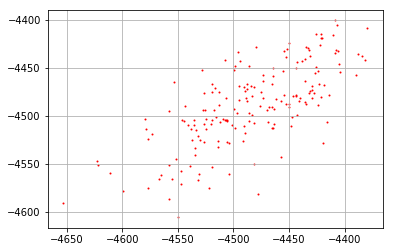

In [0]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

my_fig = plt.figure()

target_list.reshape(1, -1)[0].detach().numpy()
inference_list.reshape(1, -1)[0].detach().numpy()

for i in range(len(target_list)):
  plt.scatter(target_list[i], inference_list[i].detach().numpy(), c = 'red', s = 1)

plt.grid()

Loss on train 

In [0]:
target_list = torch.Tensor(len(train_dataloader), batch_size)
inference_list = torch.Tensor(len(train_dataloader), batch_size)

dataloader = train_dataloader
loss_value = 0.0
for idx, batch in enumerate(dataloader):
  args = batch['x'].to(device)
  val = batch['y'].to(device)

  inference = model(args)
  target_list[idx] = val * train_dataset.getStd()[74] + train_dataset.getMean()[74]
  inference_list[idx] = inference.reshape(batch_size) * train_dataset.getStd()[74] + train_dataset.getMean()[74]
  loss_value += loss(inference_list[idx], target_list[idx])

loss_value /= len(train_dataloader)
loss_value = math.sqrt(loss_value)
print('Train Loss: {:.4f} '.format(loss_value, flush=True))

Train Loss: 25.1842 


Draw inference(target) train

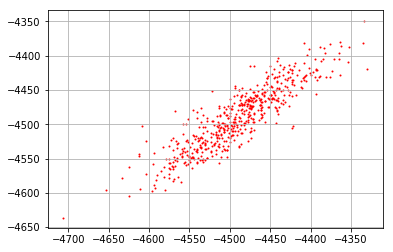

In [0]:
my_fig = plt.figure()

target_list.reshape(1, -1)[0].detach().numpy()
inference_list.reshape(1, -1)[0].detach().numpy()

for i in range(len(target_list)):
  plt.scatter(target_list[i], inference_list[i].detach().numpy(), c = 'red', s = 1)

plt.grid()

Loss(epochs) on train

ValueError: ignored

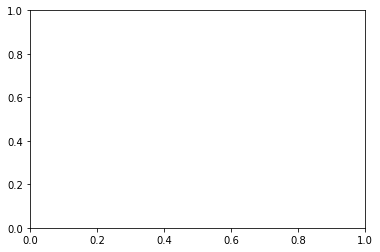

In [0]:
my_fig = plt.figure()

x = [i for i in range(num_epochs)]
y = []

file = open(path + 'ckpt' + '/' + name + '/loss_train', 'r')
for val in file:
  y.append(float(val))
file.close()

plt.plot(x, y)

plt.grid()

Loss(epochs) on validation

ValueError: ignored

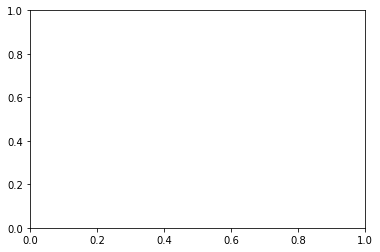

In [0]:
my_fig = plt.figure()

x = [i for i in range(num_epochs)]
y = []

file = open(path + 'ckpt' + '/' + name + '/loss_val', 'r')
for val in file:
  y.append(float(val))
file.close()

plt.plot(x, y)

plt.grid()

Optimize util 

In [50]:
device = torch.device('cpu')
model = FCNet(ct_layers, act_func, n_count)
model = model.to(device)
model.eval()
state_dict = torch.load(path + "ckpt/" + "fc7l10nv0/99" + ".ckpt") 
model.load_state_dict(state_dict)

a = [7.5] * 72
x = torch.tensor(a, requires_grad=True)
x = x.reshape(1, -1)
lr = 0.01

x_mean = torch.tensor(train_dataset.getMean()[0:72], requires_grad=False)
x_std = torch.tensor(train_dataset.getStd()[0:72], requires_grad=False)
y_mean = train_dataset.getMean()[72]
y_std = train_dataset.getStd()[72]

prev = x.clone()
prev100val = torch.zeros(1)
ok = True

for iter in range(5000):
  tmp = x.clone()
  tmp2 = (tmp - x_mean) / x_std
  val = model.forward(tmp2) * y_std + y_mean
  print('iter: ' + str(iter) + ' val: ' + str(val) + ' tilts: ')
  tmp.retain_grad()
  val.backward()
  x.data += lr * tmp.grad
  
  for i in range(72):
    if (x[0][i] < 0 or x[0][i] > 15.0):
      print('iter: ' + str(iter) + ' val: ' + str(val) + ' tilts: ')
      print(prev)
      ok = False
      break

  if (not ok):
    break
  if ((iter + 1) % 100 == 0):
    print(x)
  tmp.grad.zero_()
  prev = x.clone()
  if (iter % 100 == 0):
    if (abs(prev100val.item() - val.item()) < 1.0):
      break
    prev100val = val.clone()
# max > max(set) and max

iter: 0 val: tensor([[2.7297]], grad_fn=<AddBackward0>) tilts: 
iter: 1 val: tensor([[2.7297]], grad_fn=<AddBackward0>) tilts: 
iter: 2 val: tensor([[2.7297]], grad_fn=<AddBackward0>) tilts: 
iter: 3 val: tensor([[2.7297]], grad_fn=<AddBackward0>) tilts: 
iter: 4 val: tensor([[2.7297]], grad_fn=<AddBackward0>) tilts: 
iter: 5 val: tensor([[2.7297]], grad_fn=<AddBackward0>) tilts: 
iter: 6 val: tensor([[2.7297]], grad_fn=<AddBackward0>) tilts: 
iter: 7 val: tensor([[2.7297]], grad_fn=<AddBackward0>) tilts: 
iter: 8 val: tensor([[2.7297]], grad_fn=<AddBackward0>) tilts: 
iter: 9 val: tensor([[2.7297]], grad_fn=<AddBackward0>) tilts: 
iter: 10 val: tensor([[2.7297]], grad_fn=<AddBackward0>) tilts: 
iter: 11 val: tensor([[2.7297]], grad_fn=<AddBackward0>) tilts: 
iter: 12 val: tensor([[2.7297]], grad_fn=<AddBackward0>) tilts: 
iter: 13 val: tensor([[2.7297]], grad_fn=<AddBackward0>) tilts: 
iter: 14 val: tensor([[2.7297]], grad_fn=<AddBackward0>) tilts: 
iter: 15 val: tensor([[2.7297]], gr

In [75]:
a = [[11.0] * 72]
x = torch.tensor(a, requires_grad=True)
print(x)
opt = torch.optim.SGD([x], lr=5.0e-1, momentum = 0.95)
prev = x.clone()
ok = True
for iter in range(1000):
  tmp2 = (x - x_mean) / x_std
  val = -(model.forward(tmp2) * y_std + y_mean)
  print('itera: ' + str(iter) + ' val: ' + str(-val) + ' tilts: ')
  val.backward()
  opt.step()
  print(x)
  for j in range(72):
    if (x[0][j] < 0 or x[0][j] > 15.0):
      print('iter: ' + str(iter) + ' val: ' + str(-val) + ' tilts: ')
      print(prev)
      ok = False
      break
  if (not ok):
    break
  prev = x.clone()

tensor([[11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
         11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
         11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
         11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
         11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
         11., 11.]], requires_grad=True)
itera: 0 val: tensor([[2.7455]], grad_fn=<NegBackward>) tilts: 
tensor([[10.9998, 11.0001, 11.0000, 11.0003, 11.0004, 10.9998, 10.9997, 11.0003,
         11.0000, 11.0002, 11.0005, 10.9998, 11.0000, 10.9997, 11.0002, 11.0002,
         11.0000, 11.0001, 10.9997, 10.9997, 10.9999, 11.0003, 11.0001, 11.0001,
         10.9998, 11.0002, 11.0001, 11.0000, 11.0000, 11.0001, 11.0002, 11.0000,
         11.0002, 11.0002, 11.0001, 11.0002, 11.0002, 11.0000, 10.9998, 10.9998,
         11.0004, 11.0004, 10.9999, 10.9998, 11.0001, 10.9998, 11.0000, 11.0000,
         11.00